# Predicting MLB Strikeout Rates from Velocity and Movement

Using data from 2012-2016, we first determine a classification system for different pitches using a clustering algorithm.  Motivation for this work was provided by http://www.sloansportsconference.com/wp-content/uploads/2019/02/Predicting-Major-League-Baseball-Strikeout-Rates-Update.pdf.

These features are then used to construct a model to predict strikeout rates using several regression models.

In [1]:
from pybaseball import statcast, pitching_stats, pitching_stats_range
from collections import Counter
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score, mean_absolute_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### get the data

The raw data is scraped from statcast and/or pitch fx using the pybaseball module.  We remove "short relievers" by keeping only pitchers that have thrown at least 1000 pitches in a season AND that average 10 batters faced per appearance.

The data columns used from the pitcher data are:

- game_pk: the unique game ID
- inning: inning of the pitch
- game_year: the year of the data
- player_name: the pitcher's name (this is used to join to a separate data pull that is required to extract strikeouts per 9 innings)
- batter: used to keep track of batters faced
- release_speed: speed of the ball at time of release (feature used for pitch categorization in the clustering algorithm)
- pfx_x, pfx_z: movement in the horizontal and vertical directions (features used for pitch categorization in the clustering algorithm)

In [2]:
def avg_batters_faced(df, pitcher_id):
    
    # subset the given pitcher's games
    temp_df = df[df['pitcher']==pitcher_id]
    
    # count number of batters faced in each game
    temp_df = temp_df.drop_duplicates(subset=['game_pk', 'inning', 'batter'])
    total_batters_faced = len(temp_df)

    # count the number of appearances
    number_of_games = len(temp_df['game_pk'].unique())
    
    # return the average number of batters faced per game
    return round(total_batters_faced / number_of_games, 1)


def get_speed_location_data(start, end):

    # get the raw pitch data from statcast
    pitch_data = statcast(start_dt=start, end_dt=end)
    
    # make sure index columns are int
    pitch_data['game_pk'] = pitch_data['game_pk'].astype(int)
    pitch_data['inning'] = pitch_data['inning'].astype(int)
    pitch_data['game_year'] = pitch_data['game_year'].astype(int)
    pitch_data['pitcher'] = pitch_data['pitcher'].astype(int)
    pitch_data['batter'] = pitch_data['batter'].astype(int)
    
    # get the data for K rate and to compute the pitcher's strike percentage
    strike_data = pitching_stats(start[:4])
    strike_data = strike_data[['Season', 'Name', 'K/9', 'Pitches', 'Strikes']]
    strike_data.columns = ['game_year', 'player_name', 'K/9', 'Pitches', 'Strikes']
    strike_data['strike_pct'] = strike_data['Strikes'] / strike_data['Pitches']
    strike_data.drop(['Pitches', 'Strikes'], axis=1, inplace=True)
    strike_data['game_year'] = strike_data['game_year'].astype(int)
    
    # merge the two dataframes together
    pitch_data = pd.merge(pitch_data, strike_data, how='inner', on=['game_year', 'player_name'])
        
    # select the columns that we need
    cols_to_keep = ['game_pk', 'inning', 'game_year', 'player_name', 'pitcher', 'batter', 'release_speed', 'pfx_x', 'pfx_z', 'strike_pct', 'K/9']
    pitch_data = pitch_data[cols_to_keep]
    
    # drop any rows that have no game_pk
    pitch_data = pitch_data[~pd.isnull(pitch_data['game_pk'])]
    
    # make an index for observations 
    pitch_data['obs_index'] = pitch_data['game_year'].astype(str) + "_" + pitch_data['pitcher'].astype(str)
    
    # get a count of pitchers and number of pitches they threw
    pitcher_count = dict(Counter(pitch_data['pitcher']))

    # list of pitchers with at least 1000 pitches thrown
    pitchers_w_1000pitches = [k for k, v in pitcher_count.items() if v >= 1000]
    
    # subset the dataframe to those pitchers with at least 1000 pitches thrown
    pitch_data = pitch_data[pitch_data['pitcher'].isin(pitchers_w_1000pitches)]
    
    # list of pitchers with at least 1000 pitches thrown AND average number of batters faced per outing greater than 10
    pitchers_no_short = [x for x in pitchers_w_1000pitches if avg_batters_faced(pitch_data, x) >= 10.0]

    # subset the dataframe to those pitchers with at least 1000 pitches thrown
    pitch_data = pitch_data[pitch_data['pitcher'].isin(pitchers_no_short)]
        
    # keep only columns we need
    pitch_data = pitch_data[['obs_index', 'pitcher', 'player_name', 'release_speed', 'pfx_x', 'pfx_z', 'strike_pct', 'K/9']]
        
    return pitch_data

### get the data using pybaseball

Fill in the start and end dates of the season of interest.

In [3]:
train_data_dates = [('2012-03-28', '2012-10-03'),
                    ('2013-03-31', '2013-09-30'),
                    ('2014-03-22', '2014-09-28'),
                    ('2015-04-05', '2015-10-04'),
                    ('2016-04-03', '2016-10-02')]

train_data_list = []
for dates in train_data_dates:
    df = get_speed_location_data(start=dates[0], end=dates[1])
    train_data_list.append(df)
    
train_data = pd.concat(train_data_list)
print(f"Shape of training data: {train_data.shape}")
print(f"Number of unique pitchers in training data: {len(train_data['pitcher'].unique())}")
print(f"Number of unique observations in training data: {len(train_data['obs_index'].unique())}")

This is a large query, it may take a moment to complete
Completed sub-query from 2012-03-28 to 2012-04-02
Completed sub-query from 2012-04-03 to 2012-04-08
Completed sub-query from 2012-04-09 to 2012-04-14
Completed sub-query from 2012-04-15 to 2012-04-20
Completed sub-query from 2012-04-21 to 2012-04-26
Completed sub-query from 2012-04-27 to 2012-05-02
Completed sub-query from 2012-05-03 to 2012-05-08
Completed sub-query from 2012-05-09 to 2012-05-14
Completed sub-query from 2012-05-15 to 2012-05-20
Completed sub-query from 2012-05-21 to 2012-05-26
Completed sub-query from 2012-05-27 to 2012-06-01
Completed sub-query from 2012-06-02 to 2012-06-07
Completed sub-query from 2012-06-08 to 2012-06-13
Completed sub-query from 2012-06-14 to 2012-06-19
Completed sub-query from 2012-06-20 to 2012-06-25
Completed sub-query from 2012-06-26 to 2012-07-01
Completed sub-query from 2012-07-02 to 2012-07-07
Completed sub-query from 2012-07-08 to 2012-07-13
Completed sub-query from 2012-07-14 to 2012-

In [4]:
test_data_dates = [('2017-04-02', '2017-10-01')]

test_data_list = []
for dates in test_data_dates:
    df = get_speed_location_data(start=dates[0], end=dates[1])
    test_data_list.append(df)
    
test_data = pd.concat(test_data_list)
print(f"Shape of test data: {test_data.shape}")
print(f"Number of unique pitchers in test data: {len(test_data['pitcher'].unique())}")
print(f"Number of unique observations in test data: {len(test_data['obs_index'].unique())}")

This is a large query, it may take a moment to complete
Completed sub-query from 2017-04-02 to 2017-04-07
Completed sub-query from 2017-04-08 to 2017-04-13
Completed sub-query from 2017-04-14 to 2017-04-19
Completed sub-query from 2017-04-20 to 2017-04-25
Completed sub-query from 2017-04-26 to 2017-05-01
Completed sub-query from 2017-05-02 to 2017-05-07
Completed sub-query from 2017-05-08 to 2017-05-13
Completed sub-query from 2017-05-14 to 2017-05-19
Completed sub-query from 2017-05-20 to 2017-05-25
Completed sub-query from 2017-05-26 to 2017-05-31
Completed sub-query from 2017-06-01 to 2017-06-06
Completed sub-query from 2017-06-07 to 2017-06-12
Completed sub-query from 2017-06-13 to 2017-06-18
Completed sub-query from 2017-06-19 to 2017-06-24
Completed sub-query from 2017-06-25 to 2017-06-30
Completed sub-query from 2017-07-01 to 2017-07-06
Completed sub-query from 2017-07-07 to 2017-07-12
Completed sub-query from 2017-07-13 to 2017-07-18
Completed sub-query from 2017-07-19 to 2017-

In [5]:
train_data.head()

,obs_index,pitcher,player_name,release_speed,pfx_x,pfx_z,strike_pct,K/9
6835,2012_502706,502706,Derek Holland,82.7,0.067617,0.019400,0.638607,7.44
6836,2012_502706,502706,Derek Holland,74.9,-0.580900,-0.348967,0.638607,7.44
6837,2012_502706,502706,Derek Holland,82.6,1.224092,1.223400,0.638607,7.44
6838,2012_502706,502706,Derek Holland,94.0,1.392483,1.505767,0.638607,7.44
6839,2012_502706,502706,Derek Holland,80.8,1.141983,1.429800,0.638607,7.44


### the pitch type cluster analysis

#### select the features that we use in the clustering 

In [6]:
cluster_train_data = train_data[['pfx_x', 'pfx_z', 'release_speed']]
cluster_train_data.dropna(inplace=True)

print(f"Number of pitches in the clustering data: {cluster_train_data.shape[0]}\n")
cluster_train_data.head()

Number of pitches in the clustering data: 2105256



,pfx_x,pfx_z,release_speed
6835,0.067617,0.019400,82.7
6836,-0.580900,-0.348967,74.9
6837,1.224092,1.223400,82.6
6838,1.392483,1.505767,94.0
6839,1.141983,1.429800,80.8


#### standardize the data: scale the features to be between 0 and 1

In [7]:
pfx_x_scaler = MinMaxScaler()

pfx_x = cluster_train_data['pfx_x'].as_matrix().reshape(-1, 1)
pfx_x_scaled = pd.DataFrame(pfx_x_scaler.fit_transform(pfx_x))

pfx_z_scaler = MinMaxScaler()
pfx_z = cluster_train_data['pfx_z'].as_matrix().reshape(-1, 1)
pfx_z_scaled = pd.DataFrame(pfx_z_scaler.fit_transform(pfx_z))

release_speed_scaler = MinMaxScaler()
release_speed = cluster_train_data['release_speed'].as_matrix().reshape(-1, 1)
release_speed_scaled = pd.DataFrame(release_speed_scaler.fit_transform(release_speed))

cluster_train_data_scaled = pd.merge(pfx_x_scaled, pfx_z_scaled, left_index=True, right_index=True)
cluster_train_data_scaled = pd.merge(cluster_train_data_scaled, release_speed_scaled, left_index=True, right_index=True)

cluster_train_data_scaled.columns = ['pfx_x', 'pfx_z', 'release_speed']
cluster_train_data_scaled.head()

,pfx_x,pfx_z,release_speed
0,0.521931,0.444919,0.695652
1,0.413785,0.399181,0.574534
2,0.714783,0.594412,0.694099
3,0.742864,0.629471,0.871118
4,0.701091,0.620039,0.666149


#### DBSCAN

#### k-means with Elbow method and Silhouette averages to find optimal k

#### k-means with Gap statistic to find optimal k

In [8]:
def optimalK(data, nrefs=3, maxClusters=15):
    """
    Calculates KMeans optimal K using Gap Statistic from Tibshirani, Walther, Hastie
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters)):

        # Holder for reference dispersion results
        refDisps = np.zeros(nrefs)

        # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):
            
            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)
            
            # Fit to it
            km = KMeans(k, n_jobs=-1)
            km.fit(randomReference)
            
            refDisp = km.inertia_
            refDisps[i] = refDisp

        # Fit cluster to original data and create dispersion
        km = KMeans(k)
        km.fit(data)
        
        origDisp = km.inertia_

        # Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)

        # Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)

    return (gaps.argmax() + 1, resultsdf)  # Plus 1 because index of 0 means 1 cluster is optimal, index 2 = 3 clusters are optimal

k, _ = optimalK(cluster_train_data_scaled)
print(f"The optimal number of clusters is: {k}")

The optimal number of clusters is: 3


In [9]:
# perform k-means clustering (with number of clusters determined from elbow method)
kmeans = KMeans(n_clusters=9, n_jobs=-1).fit(cluster_train_data_scaled)

print(kmeans.score(cluster_train_data_scaled))

-14054.041725128656


### categorize pitches using k-means clusters

In [12]:
def categorize_pitches(df):

    df = df[['obs_index', 'player_name', 'pfx_x', 'pfx_z', 'release_speed']]

    df['pfx_x_scaled'] = pfx_x_scaler.transform(df['pfx_x'].as_matrix().reshape(-1,1))
    df['pfx_z_scaled'] = pfx_z_scaler.transform(df['pfx_z'].as_matrix().reshape(-1,1))
    df['release_speed_scaled'] = release_speed_scaler.transform(df['release_speed'].as_matrix().reshape(-1,1))

    df.dropna(inplace=True)

    df = df[['obs_index', 'player_name', 'pfx_x_scaled', 'pfx_z_scaled', 'release_speed_scaled']]

    df['cluster_number'] = kmeans.predict(df[['pfx_x_scaled', 'pfx_z_scaled', 'release_speed_scaled']]) 
    
    return df

train_data_categorized = categorize_pitches(train_data)

test_data_categorized = categorize_pitches(test_data)

test_data_categorized.head()

,obs_index,player_name,pfx_x_scaled,pfx_z_scaled,release_speed_scaled,cluster_number
4946,2017_656756,Jordan Montgomery,0.470616,0.537023,0.740683,0
4947,2017_656756,Jordan Montgomery,0.614863,0.686330,0.821429,4
4948,2017_656756,Jordan Montgomery,0.488993,0.423302,0.656832,5
4949,2017_656756,Jordan Montgomery,0.618048,0.666861,0.818323,4
4950,2017_656756,Jordan Montgomery,0.504702,0.465083,0.667702,0


### turn counts of cluster types into features

In [13]:
def convert_counts_to_features(df, thresh):
    
    obs_list = list(df['obs_index'].unique())

    pitch_counts_df = pd.DataFrame(columns=[0,1,2])

    for i, obs in enumerate(obs_list):

        temp_df = df[df['obs_index']==obs]

        pitch_df = pd.DataFrame(dict(Counter(temp_df['cluster_number'])), index=[obs])

        pitch_counts_df = pitch_counts_df.append(pitch_df)
        
    # if number of pitches is below thresh, replace count with NaN
    def num_pitches_thresh(x):
        if x <= thresh:
            return np.nan
        else:
            return x
    for col in pitch_counts_df.columns.tolist():
        pitch_counts_df[col] = pitch_counts_df[col].apply(num_pitches_thresh)
    return pitch_counts_df

train_pitch_counts_df = convert_counts_to_features(train_data_categorized, thresh=10)

test_pitch_counts_df = convert_counts_to_features(test_data_categorized, thresh=10)

print(train_pitch_counts_df.shape)
print(train_pitch_counts_df.head())

print(test_pitch_counts_df.shape)
print(test_pitch_counts_df.head())

(884, 9)
                 0      1      2       3       4      5       6      7      8
2012_502706  385.0    NaN  171.0     NaN  1871.0  289.0     NaN    NaN   27.0
2012_133225  940.0  299.0   15.0   168.0     NaN   45.0   818.0  460.0    NaN
2012_456167  161.0  130.0    NaN    23.0     NaN    NaN   668.0  190.0  246.0
2012_477132  187.0    NaN   41.0  1929.0   111.0  395.0   375.0  414.0    NaN
2012_285064   45.0  666.0    NaN   287.0     NaN  160.0  1091.0  425.0  380.0
(190, 9)
                 0       1      2      3       4      5      6      7      8
2017_656756  537.0     NaN  311.0  440.0   823.0  376.0    NaN    NaN   28.0
2017_592170  237.0   294.0   19.0  315.0     NaN    NaN  429.0  150.0  310.0
2017_572020  205.0     NaN   33.0  214.0  1319.0  477.0    NaN    NaN    NaN
2017_606131  541.0  1553.0    NaN    NaN     NaN  218.0  101.0   93.0   40.0
2017_621389   73.0     NaN  606.0   17.0  1483.0  306.0    NaN    NaN   24.0


#### count the number of used clusters for each observation

For comparison to the paper.

In [14]:
train_pitch_counts_df['num_clusters'] = 0

for i in range(len(train_pitch_counts_df)):
    
    train_pitch_counts_df['num_clusters'].iloc[i] = pd.notnull(train_pitch_counts_df.iloc[i,0]) + pd.notnull(train_pitch_counts_df.iloc[i,1]) +\
                                                    pd.notnull(train_pitch_counts_df.iloc[i,2]) + pd.notnull(train_pitch_counts_df.iloc[i,3]) +\
                                                    pd.notnull(train_pitch_counts_df.iloc[i,4]) + pd.notnull(train_pitch_counts_df.iloc[i,5]) +\
                                                    pd.notnull(train_pitch_counts_df.iloc[i,6]) + pd.notnull(train_pitch_counts_df.iloc[i,7]) +\
                                                    pd.notnull(train_pitch_counts_df.iloc[i,8])


train_pitch_counts_df.head()

,0,1,2,3,4,5,6,7,8,num_clusters
2012_502706,385.0,NaN,171.0,NaN,1871.0,289.0,NaN,NaN,27.0,5
2012_133225,940.0,299.0,15.0,168.0,NaN,45.0,818.0,460.0,NaN,7
2012_456167,161.0,130.0,NaN,23.0,NaN,NaN,668.0,190.0,246.0,6
2012_477132,187.0,NaN,41.0,1929.0,111.0,395.0,375.0,414.0,NaN,7
2012_285064,45.0,666.0,NaN,287.0,NaN,160.0,1091.0,425.0,380.0,7


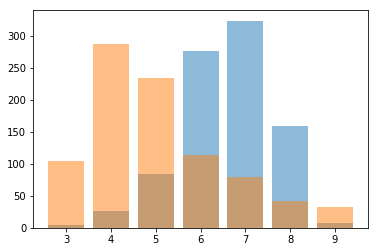

In [15]:
cluster_count = dict(Counter(train_pitch_counts_df['num_clusters']))
plt.bar(list(cluster_count.keys()), list(cluster_count.values()), alpha=0.5)
plt.bar([3, 4, 5, 6, 7, 8 , 9], [105, 287, 235, 114, 79, 42, 32], alpha=0.5)
plt.show()

### Train the Regression Models

#### Use MAPE as our evaluation Metric

In [28]:
def mean_absolute_percentage_error(y_true, y_pred): 

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#### First, train a baseline model with just release_speed and strike_pct as features

In [30]:
base_train_data = train_data[['obs_index', 'K/9', 'release_speed', 'strike_pct']]
base_train_data = pd.DataFrame(base_train_data.groupby(['obs_index', 'K/9', 'strike_pct'])['release_speed'].mean())
base_train_data.reset_index(inplace=True, drop=False)
base_train_data.drop('obs_index', axis=1, inplace=True)

base_test_data = test_data[['obs_index', 'K/9', 'release_speed', 'strike_pct']]
base_test_data = pd.DataFrame(base_test_data.groupby(['obs_index', 'K/9', 'strike_pct'])['release_speed'].mean())
base_test_data.reset_index(inplace=True, drop=False)
base_test_data.drop('obs_index', axis=1, inplace=True)
base_test_data.head()

X_train = base_train_data.drop('K/9', axis=1)
y_train = base_train_data['K/9']

X_test = base_test_data.drop('K/9', axis=1)
y_test = base_test_data['K/9']

print(f'Mean K rate for training data: {round(base_train_data["K/9"].mean(), 2)}')
print(f'Mean K rate for testing data: {round(base_test_data["K/9"].mean(), 2)}')
      
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
      
print(f'Linear Regression MAPE: {round(mean_absolute_percentage_error(y_test, y_pred), 1)}')

Mean K rate for training data: 7.31
Mean K rate for testing data: 7.94
Linear Regression MAPE: 17.2


#### Next, prepare the clustered data by merging the K rate data with pitch counts data

In [34]:
#train_data.set_index('obs_index', inplace=True, drop=True)
strike_train_data = train_data[['K/9', 'strike_pct']]

train_data_Kpct = pd.merge(strike_train_data, train_pitch_counts_df, left_index=True, right_index=True)
train_data_Kpct.drop('num_clusters', axis=1, inplace=True)
train_data_Kpct.fillna(value=0.0, inplace=True)

train_data_Kpct.drop_duplicates(inplace=True)

print(f"Shape of the training data: {train_data_Kpct.shape}")
train_data_Kpct.head()

Shape of the training data: (885, 11)


,K/9,strike_pct,0,1,2,3,4,5,6,7,8
2012_112526,5.38,0.700140,127.0,1265.0,0.0,0.0,0.0,0.0,485.0,161.0,0.0
2012_117955,3.47,0.602652,324.0,892.0,0.0,20.0,0.0,35.0,24.0,993.0,45.0
2012_119154,5.98,0.627504,486.0,750.0,24.0,414.0,0.0,0.0,565.0,183.0,158.0
2012_120485,8.24,0.650752,71.0,0.0,96.0,429.0,173.0,137.0,0.0,214.0,0.0
2012_133225,7.96,0.643013,940.0,299.0,15.0,168.0,0.0,45.0,818.0,460.0,0.0


In [37]:
#test_data.set_index('obs_index', inplace=True, drop=True)
strike_test_data = test_data[['K/9', 'strike_pct']]

test_data_Kpct = pd.merge(strike_test_data, test_pitch_counts_df, left_index=True, right_index=True)
#test_data_Kpct.drop('num_clusters', axis=1, inplace=True)
test_data_Kpct.fillna(value=0.0, inplace=True)

test_data_Kpct.drop_duplicates(inplace=True)

print(f"Shape of the test data: {test_data_Kpct.shape}")
test_data_Kpct.head()

Shape of the test data: (191, 11)


,K/9,strike_pct,0,1,2,3,4,5,6,7,8
2017_112526,5.60,0.675853,140.0,660.0,15.0,75.0,0.0,0.0,353.0,1026.0,0.0
2017_276520,5.70,0.656601,16.0,0.0,462.0,29.0,0.0,46.0,16.0,495.0,77.0
2017_282332,7.26,0.635897,229.0,0.0,364.0,545.0,472.0,206.0,0.0,515.0,0.0
2017_285079,6.44,0.660055,509.0,0.0,244.0,21.0,0.0,884.0,0.0,872.0,337.0
2017_407793,7.86,0.640332,709.0,560.0,189.0,76.0,0.0,15.0,780.0,154.0,272.0


#### Split data into training and test Sets

In [38]:
X_train = train_data_Kpct.drop('K/9', axis=1)
y_train = train_data_Kpct['K/9']

X_test = test_data_Kpct.drop('K/9', axis=1)
y_test = test_data_Kpct['K/9']

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(885, 10)
(885,)
(191, 10)
(191,)


#### Linear Regression

In [40]:
lin_reg = LinearRegression()

lin_reg.fit(X_train, y_train)

y_pred = lin_reg.predict(X_test)

print(f"Mean Absolute Percentage Error: {round(mean_absolute_percentage_error(y_test, y_pred), 1)}")

Mean Absolute Error: 17.0


#### (Off-the-shelf) Random Forest

In [41]:
rf_reg = RandomForestRegressor()

rf_reg.fit(X_train, y_train)

y_pred = rf_reg.predict(X_test)

print(f"Mean Absolute Percentage Error: {round(mean_absolute_percentage_error(y_test, y_pred), 1)}")

Mean Absolute Error: 17.5


#### (Off-the-shelf) AdaBoost 

In [42]:
ab_reg = AdaBoostRegressor()

ab_reg.fit(X_train, y_train)

y_pred = ab_reg.predict(X_test)

print(f"Mean Absolute Percentage Error: {round(mean_absolute_percentage_error(y_test, y_pred), 1)}")

Mean Absolute Error: 17.0


#### Optimized Random Forest

Using Scikit-Learn's GridSearchCV to find the optimal set of hyperparameters.

In [43]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

y_pred = grid_search.predict(X_test)

print(f"Mean Absolute Percentage Error: {round(mean_absolute_percentage_error(y_test, y_pred), 1)}")

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   55.0s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  2.4min finished


{'bootstrap': True, 'max_depth': 110, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 1000}
Mean Absolute Error: 16.3


#### Optimized AdaBoost

In [44]:
param_grid = {
    'n_estimators': [10, 20, 50, 100, 200, 300, 1000],
    'learning_rate': [0.1, 0.5, 1.0, 5.0, 10.0],
    'loss': ['linear', 'square', 'exponential']
}
# Create a based model
ab = AdaBoostRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = ab, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

y_pred = grid_search.predict(X_test)

print(f"Mean Absolute Percentage Error: {round(mean_absolute_percentage_error(y_test, y_pred), 1)}")

Fitting 3 folds for each of 105 candidates, totalling 315 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 273 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done 315 out of 315 | elapsed:   26.3s finished


{'learning_rate': 0.5, 'loss': 'exponential', 'n_estimators': 100}
Mean Absolute Percentage Error: 16.9
